In [73]:
!pip install ta

In [74]:
!pip install tensorflow

In [75]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator
import seaborn as sns
import matplotlib.pyplot as plt






In [76]:
# import GME data
GME = yf.Ticker("GME")
df = GME.history(period="10y")
df.reset_index(inplace=True)
df.drop(['Dividends', 'Stock Splits', 'Date'], axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,8.064223,8.186437,7.959195,8.169250,6061600
1,8.180709,8.249454,8.069952,8.243725,5638800
2,8.260912,8.272370,8.165432,8.211263,4498400
3,8.201713,8.430865,8.192165,8.398401,6159200
4,8.400312,8.484334,8.186437,8.327747,6796400


In [77]:
# calculate the technical indicators
df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
df['SMA20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
df['MACD'] = MACD(df['Close']).macd()
df['BB_high'] = BollingerBands(df['Close']).bollinger_hband()
df['BB_low'] = BollingerBands(df['Close']).bollinger_lband()
df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,RSI,SMA20,MACD,BB_high,BB_low,OBV
25,8.455690,8.495792,8.323928,8.490063,3594000,63.104175,8.085801,0.088081,8.624799,7.546804,16230400
26,8.490063,8.581724,8.404131,8.539713,3046400,64.607555,8.114445,0.102711,8.685071,7.543820,19276800
27,8.551170,8.711576,8.541622,8.612277,6144800,66.740562,8.150250,0.118792,8.750687,7.549814,25421600
28,8.646650,8.824242,8.618006,8.791780,4631600,71.341700,8.197608,0.144356,8.841956,7.553261,30053200
29,8.818513,9.026659,8.705846,8.971280,6262000,75.057635,8.252796,0.177059,8.960556,7.545035,36315200


In [78]:
#create target column
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.head()

,Open,High,Low,Close,Volume,RSI,SMA20,MACD,BB_high,BB_low,OBV,Target
25,8.455690,8.495792,8.323928,8.490063,3594000,63.104175,8.085801,0.088081,8.624799,7.546804,16230400,1
26,8.490063,8.581724,8.404131,8.539713,3046400,64.607555,8.114445,0.102711,8.685071,7.543820,19276800,1
27,8.551170,8.711576,8.541622,8.612277,6144800,66.740562,8.150250,0.118792,8.750687,7.549814,25421600,1
28,8.646650,8.824242,8.618006,8.791780,4631600,71.341700,8.197608,0.144356,8.841956,7.553261,30053200,1
29,8.818513,9.026659,8.705846,8.971280,6262000,75.057635,8.252796,0.177059,8.960556,7.545035,36315200,0


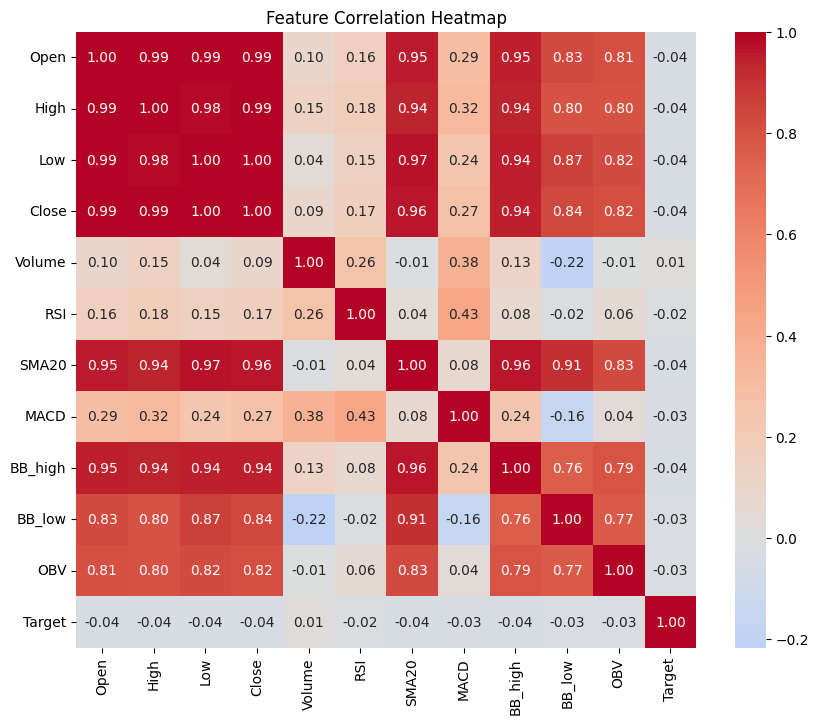

In [79]:
# Data preparation
correlation_matrix = df.corr()
# print(correlation_matrix)

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [80]:
from sklearn.preprocessing import MinMaxScaler

# Included all features
features = ['Open','High','Low','Close','Volume','RSI','SMA20','MACD','BB_high','BB_low','OBV']
target = 'Close'  # Will do regression instead

X = df[features].values
y = df[target].values.reshape(-1, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2490, 11)
y shape: (2490, 1)


In [81]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

print("X_scaled:", X_scaled[:5])
# print("y_scaled:", y_scaled[:5])


X_scaled: [[0.08218638 0.06466518 0.10633942 0.09039555 0.00313812 0.58280668
  0.12033946 0.21821906 0.09690331 0.48213093 0.06000846]
 [0.08255122 0.06538119 0.10744972 0.09097169 0.00244277 0.60054991
  0.12081959 0.2189922  0.09767051 0.4820922  0.06043796]
 [0.08319981 0.06646316 0.10935311 0.09181372 0.0063772  0.62572414
  0.12141975 0.21984198 0.09850575 0.48216999 0.06130429]
 [0.08421324 0.06740193 0.11041055 0.09389666 0.0044557  0.6800278
  0.12221356 0.22119293 0.09966751 0.48221474 0.06195729]
 [0.08603739 0.06908852 0.11162658 0.09597958 0.00652602 0.7238841
  0.12313861 0.22292113 0.10117719 0.48210797 0.06284015]]


In [82]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
seq_len=20
X_seq, y_seq=[],[]
for i in range(len(X_scaled)-seq_len):
  X_seq.append(X_scaled[i:i+seq_len])
  y_seq.append(y_scaled[i+seq_len])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (2470, 20, 11)
y_seq shape: (2470, 1)


In [84]:
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [144]:
num_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_len, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.99)
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 20, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,393 (794.50 KB)

 Trainable params: 203,393 (794.50 KB)

 Non-trainable params: 0 (0.00 B)

In [145]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=150,
    batch_size=32,
    shuffle=False,
    callbacks=[early_stopping]
)


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0044 - val_loss: 0.0113
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0019 - val_loss: 5.3287e-04
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0023 - val_loss: 4.3910e-04
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0026 - val_loss: 3.3528e-04
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 8/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0033 - val_loss: 0.0075
Epoch 9/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0025 - val_loss: 0.0085
Epoch 10/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 11/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 7.6631e-04 - val_loss: 2.8891e-04
Epoch 12/150
56/56 ━━━━━━━━━━━━━

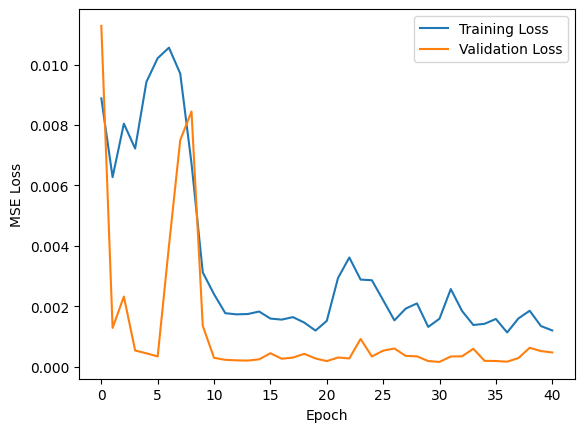

In [146]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [147]:

y_pred_scaled = model.predict(X_test)


y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_actual = target_scaler.inverse_transform(y_test)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [148]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)

MSE : 5.064361663772432
RMSE: 2.250413665034149
MAE : 1.1704045770621976
R²  : 0.8615183052642589


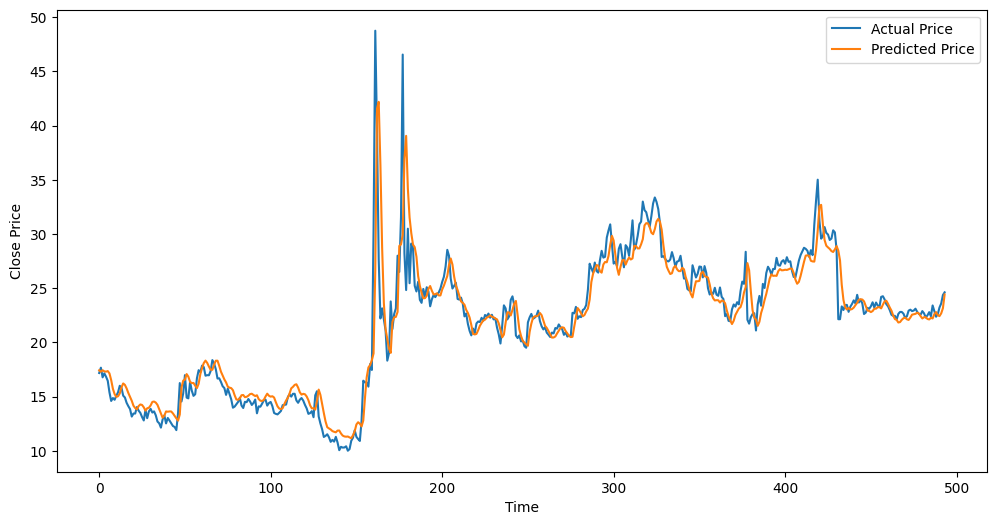

In [149]:
plt.figure(figsize=(12,6))
plt.plot(y_actual, label="Actual Price")
plt.plot(y_pred, label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


Predicted Close for tomorrow: 24.64


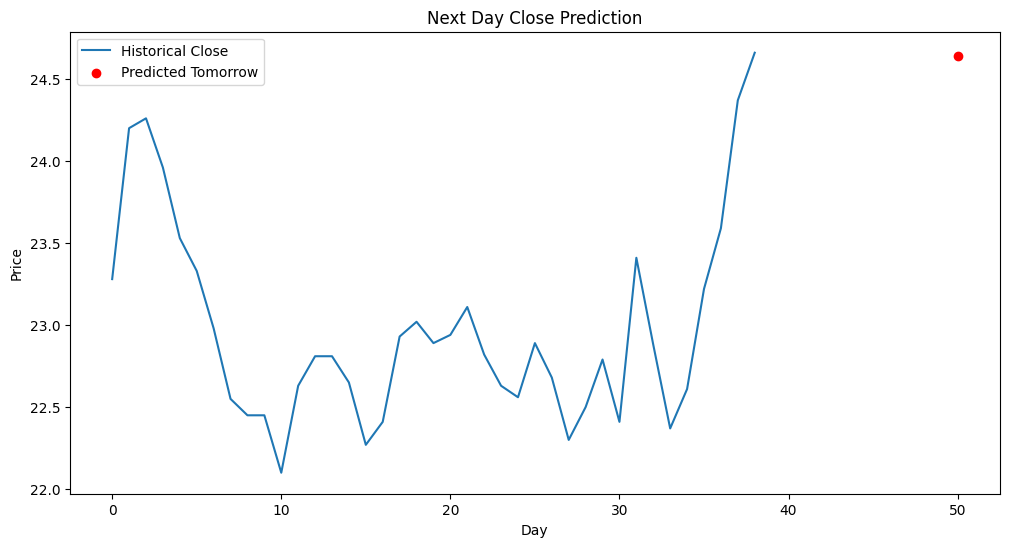

In [150]:
# --- Load latest data ---
gme_data = yf.Ticker("GME").history(period="3mo")
gme_data.reset_index(inplace=True)
gme_data.drop(['Dividends', 'Stock Splits', 'Date'], axis=1, inplace=True)

# --- Calculate technical indicators ---
gme_data['RSI'] = RSIIndicator(gme_data['Close'], window=14).rsi()
gme_data['SMA20'] = SMAIndicator(gme_data['Close'], window=20).sma_indicator()
gme_data['MACD'] = MACD(gme_data['Close']).macd()
gme_data['BB_high'] = BollingerBands(gme_data['Close']).bollinger_hband()
gme_data['BB_low'] = BollingerBands(gme_data['Close']).bollinger_lband()
gme_data['OBV'] = OnBalanceVolumeIndicator(gme_data['Close'], gme_data['Volume']).on_balance_volume()
gme_data.dropna(inplace=True)
gme_data.head()

# --- Features and target ---
feature_cols = ['Open','High','Low','Close','Volume','RSI','SMA20','MACD','BB_high','BB_low','OBV']

X_gme = gme_data[feature_cols].values

# --- Scale features using scalers from training ---
X_gme_scaled = feature_scaler.transform(X_gme)

# --- Prepare last 20-day sequence for prediction ---
seq_len = 20
x_input_gme = X_gme_scaled[-seq_len:]  # shape (20, num_features)
x_input_gme = x_input_gme.reshape(1, seq_len, len(feature_cols))  # shape (1, 20, num_features)

# --- Predict next day Close ---
pred_tomorrow_scaled = model.predict(x_input_gme, verbose=0)
pred_tomorrow = target_scaler.inverse_transform(pred_tomorrow_scaled)[0, 0]

print(f"Predicted Close for tomorrow: {pred_tomorrow:.2f}")

# --- Plot last 50 days + prediction ---
last_n_days = 50
plt.figure(figsize=(12,6))
plt.plot(gme_data['Close'].values[-last_n_days:], label='Historical Close')
plt.scatter(last_n_days, pred_tomorrow, color='red', label='Predicted Tomorrow', zorder=5)
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Next Day Close Prediction')
plt.legend()
plt.show()